### Adjust the Labels

In [3]:
import os
from glob import glob

label_dirs = ["/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/train/labels", "/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/labels"]

for label_dir in label_dirs:
    for file in glob(f"{label_dir}/*.txt"):
        with open(file, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                parts[0] = "0"  
                new_lines.append(" ".join(parts))

        with open(file, "w") as f:
            f.write("\n".join(new_lines))
print("Label files updated successfully.")


Label files updated successfully.


In [ ]:
# Path to folder containing negative images
image_folder = 'negative_images'

# Supported image extensions (you can add more if needed)
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

# Loop through files in the folder
for filename in os.listdir(image_folder):
    name, ext = os.path.splitext(filename)
    if ext.lower() in image_extensions:
        # Create an empty .txt file with the same name as the image
        label_path = os.path.join(image_folder, name + '.txt')
        if not os.path.exists(label_path):
            with open(label_path, 'w') as f:
                pass  # Just create an empty file
            print(f"Created: {label_path}")
        else:
            print(f"Already exists: {label_path}")


In [ ]:
import shutil

# Folder where the mixed files are located
source_folder = 'negative_images'

# Destination folders
image_dest = os.path.join(source_folder, 'images')
label_dest = os.path.join(source_folder, 'labels')

# Create destination folders if they don't exist
os.makedirs(image_dest, exist_ok=True)
os.makedirs(label_dest, exist_ok=True)

# Supported image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

# Move files
for filename in os.listdir(source_folder):
    filepath = os.path.join(source_folder, filename)
    if os.path.isfile(filepath):
        name, ext = os.path.splitext(filename)
        ext = ext.lower()
        if ext in image_extensions:
            shutil.move(filepath, os.path.join(image_dest, filename))
            print(f"Moved image: {filename}")
        elif ext == '.txt':
            shutil.move(filepath, os.path.join(label_dest, filename))
            print(f"Moved label: {filename}")


In [ ]:
import random

# Paths
negative_folder_imgs = 'negative_images/images'
negative_folder_labels = 'negative_images/labels'
train_images_folder = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/train/images'
train_labels_folder = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/train/labels'
val_images_folder = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/images'
val_labels_folder = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/labels'

# Create folders if they don't exist
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

# Get all image files (assuming .jpg or .png)
image_extensions = ['.jpg', '.jpeg', '.png']
all_images = [f for f in os.listdir(negative_folder_imgs) if os.path.splitext(f)[1].lower() in image_extensions]

# Shuffle and split
random.shuffle(all_images)
split_index = int(0.13 * len(all_images))
val_images = all_images[:split_index]
train_images = all_images[split_index:]

def copy_pair(image_list, dest_img_folder, dest_lbl_folder):
    for img in image_list:
        img_src = os.path.join(negative_folder_imgs, img)
        lbl_src = os.path.join(negative_folder_labels, os.path.splitext(img)[0] + '.txt')

        shutil.copy(img_src, os.path.join(dest_img_folder, img))

        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, os.path.join(dest_lbl_folder, os.path.basename(lbl_src)))
        else:
            # If label is missing, create an empty one
            open(os.path.join(dest_lbl_folder, os.path.splitext(img)[0] + '.txt'), 'w').close()

# Copy training and validation sets
copy_pair(train_images, train_images_folder, train_labels_folder)
copy_pair(val_images, val_images_folder, val_labels_folder)

print(f"Moved {len(train_images)} images to training set and {len(val_images)} to validation set.")


Moved 7830 images to training set and 1170 to validation set.


### Test YOLO

In [42]:
from ultralytics import YOLO
import cv2

# Load your trained model (.pt file)
model = YOLO("/home/group02-f24/Documents/Khalil/CV/ultralytics/runs/detect/train6/weights/best.pt")  # adjust the path if different

# Load an image
image_path = "/home/group02-f24/Documents/Khalil/CV/Templates/Knives/41BgHoEfRSL.jpg"  # change this to your actual image
results = model(image_path)

# Show results on image (opens a window)
results[0].show()

# Optionally, save results to a file
results[0].save(filename="predicted.jpg")



image 1/1 /home/group02-f24/Documents/Khalil/CV/Templates/Knives/41BgHoEfRSL.jpg: 416x640 (no detections), 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 640)


'predicted.jpg'

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/group02-f24/snap/code/common/.cache/gio-modules/libgiolibproxy.so


### Find Threshold

In [6]:
from ultralytics import YOLO
import glob, cv2
from pathlib import Path

model = YOLO('/home/group02-f24/Documents/Khalil/CV/ultralytics/runs/detect/train6/weights/best.pt')

IMG_DIR = Path('/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/images')
TXT_DIR = Path('/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/labels')

img_paths = sorted(IMG_DIR.glob('*.jpg'))

all_preds = []   # will hold tuples (img_id, box, score)
all_gts   = {}   # img_id -> list of GT boxes

def load_yolo_txt(path, img_shape):
    h, w = img_shape[:2]
    gts = []
    for line in open(path):
        cls, xc,yc,wd,ht = map(float,line.split())
        x1 = (xc - wd/2)*w
        y1 = (yc - ht/2)*h
        x2 = (xc + wd/2)*w
        y2 = (yc + ht/2)*h
        gts.append([x1,y1,x2,y2])
    return gts

for img_path in img_paths:
    img = cv2.imread(str(img_path))
    results = model.predict(img, conf=0.001, verbose=False)[0]
    img_id = img_path.stem

    # store predictions
    for box, conf in zip(results.boxes.xyxy.cpu().numpy(), results.boxes.conf.cpu().numpy()):
        all_preds.append((img_id, box, float(conf)))

    # load GT for this image
    txt_path = TXT_DIR / f"{img_id}.txt"
    all_gts[img_id] = load_yolo_txt(txt_path, img.shape)

### Match preds to GT → build y_true & y_scores

In [7]:
import numpy as np

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter + 1e-8)

# sort preds by descending confidence
all_preds.sort(key=lambda x: x[2], reverse=True)

y_true   = []
y_scores = []

# track which GTs have been “used” per image
used_gt = {img_id: np.zeros(len(gts),dtype=bool) for img_id,gts in all_gts.items()}

for img_id, box, conf in all_preds:
    gts = all_gts[img_id]
    ious = [iou(box, gt) for gt in gts]
    best_idx = np.argmax(ious) if gts else None
    best_iou = ious[best_idx] if gts else 0.0

    if best_iou >= 0.5 and not used_gt[img_id][best_idx]:
        # True Positive
        y_true.append(1)
        used_gt[img_id][best_idx] = True
    else:
        # False Positive
        y_true.append(0)

    y_scores.append(conf)

### Compute the precision–recall curve

In [8]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

### Find your operating threshold

In [9]:
fpr = 1 - precision
mask = (recall[:-1] >= 0.90) & (fpr[:-1] <= 0.37)
if mask.any():
    opt_thresh = thresholds[mask].min()
    print(f"→ Use confidence threshold = {opt_thresh:.3f}")
else:
    print("No single threshold meets 90% recall & ≤10% FPR; consider relaxing one target.")

→ Use confidence threshold = 0.115


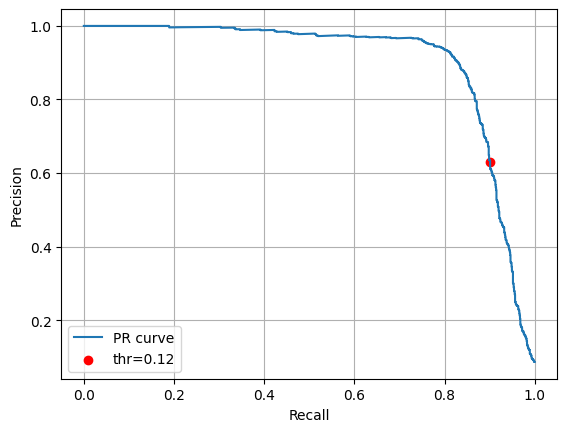

In [10]:
import matplotlib.pyplot as plt

plt.plot(recall, precision, label='PR curve')
# mark the operating point
idx = np.where(thresholds == opt_thresh)[0][0]
plt.scatter(recall[idx], precision[idx], color='red', label=f'thr={opt_thresh:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.grid(True)
plt.show()

### Re-run inference at the chosen threshold

In [11]:
yolo_thresh = 0.115

fp_examples = []   # will hold (img_id, box, score)
fn_examples = []   # will hold (img_id, gt_box)

# track which GTs get matched
used_gt = {img_id: np.zeros(len(gts),dtype=bool) for img_id,gts in all_gts.items()}

for img_id, box, conf in all_preds:
    if conf < yolo_thresh:
        continue

    # find best-overlapping GT
    gts = all_gts[img_id]
    ious = [iou(box, gt) for gt in gts]
    if gts and max(ious) >= 0.3:
        best_idx = int(np.argmax(ious))
        if not used_gt[img_id][best_idx]:
            used_gt[img_id][best_idx] = True
        else:
            # matched this GT already → extra detection is FP
            fp_examples.append((img_id, box, conf))
    else:
        # no GT with IoU≥0.5 → FP
        fp_examples.append((img_id, box, conf))

# any GT not used → false negative
for img_id, gts in all_gts.items():
    for idx, gt in enumerate(gts):
        if not used_gt[img_id][idx]:
            fn_examples.append((img_id, gt))

### Manual Scenario Labeling

In [12]:
import os, cv2

os.makedirs('error_analysis/FP', exist_ok=True)
os.makedirs('error_analysis/FN', exist_ok=True)

# save up to 200 examples of each
for i, (img_id, box, _) in enumerate(fp_examples[:1000]):
    img = cv2.imread(f'{IMG_DIR}/{img_id}.jpg')
    x1,y1,x2,y2 = map(int, box)
    roi = img[y1:y2, x1:x2]
    cv2.imwrite(f'error_analysis/FP/fp_{i}_{img_id}.jpg', roi)

for i, (img_id, gt) in enumerate(fn_examples[:1000]):
    img = cv2.imread(f'{IMG_DIR}/{img_id}.jpg')
    x1,y1,x2,y2 = map(int, gt)
    roi = img[y1:y2, x1:x2]
    cv2.imwrite(f'error_analysis/FN/fn_{i}_{img_id}.jpg', roi)

In [ ]:
import cv2
import os

# --- Inputs ---
image_path = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/images/086_jpg.rf.220466e7f936848b457b9d64f55a5057.jpg'
label_path = '/home/group02-f24/Documents/Khalil/CV/weapon-detection.v16-remapped-train-80-val-20.yolov11/valid/labels/086_jpg.rf.220466e7f936848b457b9d64f55a5057.txt'

# Load image
img = cv2.imread(image_path)
h, w, _ = img.shape

# Read YOLO label
with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())

    # Convert to pixel coordinates
    x_center *= w
    y_center *= h
    box_width *= w
    box_height *= h

    # Get top-left and bottom-right corners
    x1 = int(x_center - box_width / 2)
    y1 = int(y_center - box_height / 2)
    x2 = int(x_center + box_width / 2)
    y2 = int(y_center + box_height / 2)

    # Draw rectangle and label
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"Class {int(class_id)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show or save
cv2.imshow("GT Box", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Or save: cv2.imwrite("output.jpg", img)


### Preprocess and Normalize Templates

In [60]:
import cv2
import numpy as np
import os

input_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale'   
output_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges'  
os.makedirs(output_dir, exist_ok=True)

MODE = 'edges'  # options: 'grayscale', 'binary', 'edges'
TARGET_HEIGHT = 200

for filename in os.listdir(input_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        continue

    tpl_path = os.path.join(input_dir, filename)

    # 1. Read and convert to grayscale
    tpl = cv2.imread(tpl_path)
    if tpl is None:
        print(f"Skipping unreadable file: {filename}")
        continue
    tpl_gray = cv2.cvtColor(tpl, cv2.COLOR_BGR2GRAY)

    # 2. Optionally binarize or detect edges
    if MODE == 'binary':
        _, processed = cv2.threshold(tpl_gray, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    elif MODE == 'edges':
        processed = cv2.Canny(tpl_gray, 50, 150)
    else:
        processed = tpl_gray

    # 3. Resize to a standard height, preserving aspect ratio
    scale = TARGET_HEIGHT / processed.shape[0]
    processed = cv2.resize(processed, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    # 4. Save the result
    out_path = os.path.join(output_dir, f"processed_{filename}")
    cv2.imwrite(out_path, processed)

print("✅ Processing complete.")


✅ Processing complete.


### Augment the results

In [63]:
def augment(template, angles=[-30, 0, 30, 90, -90, 180], scales=[0.25, 0.5, 0.75, 1.0]):
    """Rotate and scale the image to create augmented versions."""
    outs = []
    h, w = template.shape[:2]
    for a in angles:
        M = cv2.getRotationMatrix2D((w / 2, h / 2), a, 1.0)
        rot = cv2.warpAffine(template, M, (w, h))
        for s in scales:
            resized = cv2.resize(rot, None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
            outs.append((a, s, resized))
    return outs

input_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_binary'
output_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_binary_augmented'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        continue

    tpl_path = os.path.join(input_dir, filename)
    tpl = cv2.imread(tpl_path)

    if tpl is None:
        print(f"Skipping unreadable file: {filename}")
        continue

    base_name, ext = os.path.splitext(filename)
    augmented = augment(tpl)

    for idx, (angle, scale, aug_img) in enumerate(augmented):
        out_filename = f"{base_name}_rot{angle}_scale{scale:.2f}{ext}"
        out_path = os.path.join(output_dir, out_filename)
        cv2.imwrite(out_path, aug_img)

print("✅ Augmentation complete.")


✅ Augmentation complete.


###  Extract & Store Descriptors

In [66]:
import numpy as np
import pickle

input_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_augmented'
keypoints_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_kp'
descriptors_dir = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_desc'

# Create output directories if they don't exist
os.makedirs(keypoints_dir, exist_ok=True)
os.makedirs(descriptors_dir, exist_ok=True)

sift = cv2.SIFT_create()

for filename in os.listdir(input_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.png')):
        continue

    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Skipping unreadable file: {filename}")
        continue

    # Compute keypoints and descriptors
    kp, desc = sift.detectAndCompute(img, None)
    if desc is None:
        print(f"No descriptors found for {filename}")
        continue

    base_name = os.path.splitext(filename)[0]

    # Save keypoints (as list of cv2.KeyPoint is not directly serializable, we convert)
    kp_data = [(k.pt, k.size, k.angle, k.response, k.octave, k.class_id) for k in kp]
    with open(os.path.join(keypoints_dir, f'{base_name}_kp.pkl'), 'wb') as f:
        pickle.dump(kp_data, f)

    # Save descriptors
    np.save(os.path.join(descriptors_dir, f'{base_name}_desc.npy'), desc)

print("✅ Keypoints and descriptors saved.")

No descriptors found for processed_41BgHoEfRSL_rot-30_scale0.25.jpg
No descriptors found for processed_41BgHoEfRSL_rot-90_scale0.25.jpg
✅ Keypoints and descriptors saved.


### Integrate at Inference

In [ ]:
# Load the YOLO model
model = YOLO("/home/group02-f24/Documents/Khalil/CV/ultralytics/runs/detect/train6/weights/best.pt")
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

# Load precomputed template keypoints and descriptors
template_folder = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_augmented'
keypoint_folder = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_kp'
descriptor_folder = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_desc'

templates = []
for name in os.listdir(descriptor_folder):
    base = name.replace('_desc.npy', '')
    tpl = cv2.imread(os.path.join(template_folder, f'{base}.png'), cv2.IMREAD_GRAYSCALE)
    if tpl is None:
        continue
    desc = np.load(os.path.join(descriptor_folder, name))
    with open(os.path.join(keypoint_folder, f'{base}_kp.pkl'), 'rb') as f:
        kp = pickle.load(f)
        kp = [cv2.KeyPoint(x=pt[0][0], y=pt[0][1], _size=pt[1], _angle=pt[2],
                           _response=pt[3], _octave=pt[4], _class_id=pt[5]) for pt in kp]
    templates.append((tpl, kp, desc))

# Inference on a test image
img_path = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives/41BgHoEfRSL.jpg'
img = cv2.imread(img_path)
results = model(img)[0]

yolo_thresh = 0.115

accepted_detections = []

for box in results.boxes:
    conf = float(box.conf)
    if conf < yolo_thresh:
        continue

    x1, y1, x2, y2 = map(int, box.xyxy[0])
    roi = img[y1:y2, x1:x2]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # --- Keypoint Matching ---
    kp_roi, desc_roi = sift.detectAndCompute(roi_gray, None)
    kp_score = 0
    if desc_roi is not None:
        best_match_count = 0
        for tpl_img, tpl_kp, tpl_desc in templates:
            matches = bf.knnMatch(desc_roi, tpl_desc, k=2)
            good = [m for m, n in matches if m.distance < 0.75 * n.distance]
            best_match_count = max(best_match_count, len(good))
        kp_score = min(1.0, best_match_count / 30.0)  # normalize

    # --- Template Matching ---
    tm_score = 0
    for tpl_img, _, _ in templates:
        resized = cv2.resize(roi_gray, (tpl_img.shape[1], tpl_img.shape[0]))
        res = cv2.matchTemplate(resized, tpl_img, cv2.TM_CCOEFF_NORMED)
        tm_score = max(tm_score, res.max())

    # --- Score Fusion ---
    print(f"Conf: {conf:.2f}, Keypoint Score: {kp_score:.2f}, Template Match Score: {tm_score:.2f}")
    final_score = 0.6 * conf + 0.25 * kp_score + 0.15 * max(tm_score, 0)
    if final_score > 0.4:
        accepted_detections.append((x1, y1, x2, y2, final_score))

# Draw accepted detections
for x1, y1, x2, y2, score in accepted_detections:
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{score:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

cv2.imwrite('filtered_output.jpg', img)


[ WARN:0@12556.424] global loadsave.cpp:268 findDecoder imread_('/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_augmented/processed_knife_92766706_rot90_scale1.00.png'): can't open/read file: check file path/integrity
[ WARN:0@12556.424] global loadsave.cpp:268 findDecoder imread_('/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_augmented/processed_processed_41BgHoEfRSL_rot30_scale0.75.png'): can't open/read file: check file path/integrity
[ WARN:0@12556.424] global loadsave.cpp:268 findDecoder imread_('/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_augmented/processed_processed_51tXSzVc7AL._AC_UF894,1000_QL80__rot0_scale1.00.png'): can't open/read file: check file path/integrity
[ WARN:0@12556.424] global loadsave.cpp:268 findDecoder imread_('/home/group02-f24/Documents/Khalil/CV/Templates/Knives_edges_augmented/processed_japanese-proti-knife-glestain-018tk-size-18cm-id4798-018tk-japanese-knife-glestain_rot30_scale0.25.png'): can't open/read fi


0: 416x640 (no detections), 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 640)


True

### Test SIFT alone

In [99]:
import os
import cv2
import pickle
import numpy as np

# Folders
template_folder     = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_augmented'
keypoint_folder     = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_kp'
descriptor_folder   = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives_grayscale_desc'

# SIFT and matcher
sift = cv2.SIFT_create()
bf   = cv2.BFMatcher()

# Load templates
templates = []
for name in os.listdir(descriptor_folder):
    if not name.endswith('_desc.npy'): continue

    base = name.replace('_desc.npy','')
    tpl_path   = os.path.join(template_folder, f"{base}.jpg")
    desc_path  = os.path.join(descriptor_folder, name)
    kp_path    = os.path.join(keypoint_folder, f"{base}_kp.pkl")
    if not os.path.exists(tpl_path): continue

    tpl_img = cv2.imread(tpl_path, cv2.IMREAD_GRAYSCALE)
    tpl_desc = np.load(desc_path, allow_pickle=True)
    if tpl_desc is None or len(tpl_desc) < 2: continue

    with open(kp_path,'rb') as f:
        kp_serial = pickle.load(f)
        tpl_kp = [cv2.KeyPoint(pt[0][0],pt[0][1],pt[1],pt[2],pt[3],pt[4],pt[5])
                  for pt in kp_serial]

    templates.append((tpl_img, tpl_kp, tpl_desc))


def sift_only_detect(gray_img, templates,
                     ratio_thresh=0.5,
                     min_good=5,
                     min_inliers=10,
                     min_ratio=0.05):
    """
    Returns True if a knife is detected in gray_img via SIFT+RANSAC.
    """
    kp_img, desc_img = sift.detectAndCompute(gray_img, None)
    if desc_img is None or len(desc_img) < 2:
        return False

    for tpl_img, tpl_kp, tpl_desc in templates:
        # 1) match descriptors
        matches = bf.knnMatch(desc_img, tpl_desc, k=2)
        good = []
        for pair in matches:
            if len(pair) != 2:
                continue
            m, n = pair
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
        # 2) absolute match count
        if len(good) < min_good:
            continue
        # 3) geometric consistency
        src_pts = np.float32([kp_img[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([tpl_kp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        inliers = int(mask.sum()) if mask is not None else 0
        if inliers < min_inliers:
            continue
        # 4) relative match ratio
        if len(good) / len(desc_img) < min_ratio:
            continue

        # all checks passed!
        return True

    return False


# ----------------------
# Apply it to your test image:
# ----------------------
test_image_path = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives/images.jpg'
img  = cv2.imread(test_image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if sift_only_detect(gray, templates):
    cv2.putText(img, "Knife DETECTED", (20,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
else:
    cv2.putText(img, "No knife", (20,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 2)

cv2.imwrite("sift_only_result.jpg", img)

True

In [57]:
import os
import cv2

def convert_images_to_jpg(root_folder, delete_original=False):
    supported_extensions = {'.png', '.jpeg', '.bmp', '.tiff', '.webp', '.jfif'}  # Extend as needed
    converted_count = 0

    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            name, ext = os.path.splitext(filename)
            ext_lower = ext.lower()

            if ext_lower in supported_extensions:
                new_filename = name + '.jpg'
                new_path = os.path.join(dirpath, new_filename)

                # Skip if JPG version already exists
                if os.path.exists(new_path):
                    print(f"[SKIP] {new_path} already exists.")
                    continue

                # Load and convert
                img = cv2.imread(file_path)
                if img is None:
                    print(f"[WARN] Could not read: {file_path}")
                    continue

                # Write as JPG
                success = cv2.imwrite(new_path, img)
                if success:
                    converted_count += 1
                    print(f"[OK] Converted: {file_path} → {new_path}")
                    if delete_original:
                        os.remove(file_path)
                        print(f"     Deleted original: {file_path}")
                else:
                    print(f"[ERROR] Failed to write JPG: {new_path}")

    print(f"\n✅ Conversion complete. Total converted: {converted_count}")


# ==== CONFIG ====
FOLDER = '/home/group02-f24/Documents/Khalil/CV/Templates/Knives'  # <<<< CHANGE THIS
DELETE_ORIGINALS = True  # Set to True to delete originals

convert_images_to_jpg(FOLDER, delete_original=DELETE_ORIGINALS)


[OK] Converted: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (3).jpeg → /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (3).jpg
     Deleted original: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (3).jpeg
[OK] Converted: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (2).jpeg → /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (2).jpg
     Deleted original: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (2).jpeg
[OK] Converted: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images.jpeg → /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images.jpg
     Deleted original: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images.jpeg
[OK] Converted: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (1).jpeg → /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (1).jpg
     Deleted original: /home/group02-f24/Documents/Khalil/CV/Templates/Knives/images (1).jpeg
